# Expectation-maximization algorithm

The purpose here is to derive and implement formulas for the Gaussian Mixture Model (GMM) — one of the most commonly used methods for performing soft clustering of the data. 

This was completed as part of the Bayesian course on the Advanced Machine Learning Specialisation on Coursera. The data used for this notebook was downloaded from the following link: https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week2/samples.npz. For debugging, samples from a Gaussian mixture model with unknown mean, variance, and priors were used. Initial values of parameters were also added.

In [1]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
%matplotlib inline

## Implementing EM for GMM

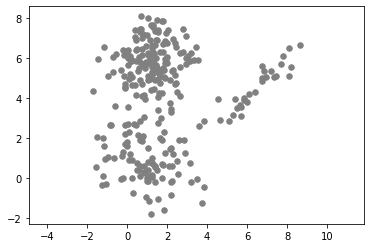

In [2]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

The EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

### E-step
In this step, the posterior distribution is estimated over the latent variables with fixed values of parameters: $q_i(t_i) = p(t_i \mid x_i, \theta)$. It is assumed that $t_i$ equals to the cluster index of the true component of the $x_i$ object. To do so $\gamma_{ic} = p(t_i = c \mid x_i, \theta)$ must be computed. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


In [3]:
from scipy.stats import multivariate_normal
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    for c in range(C):
        gamma[:, c] = pi[c] * multivariate_normal(mean=mu[c, :], cov=sigma[c, :]).pdf(X)
    gamma = gamma / np.sum(gamma, axis=1, keepdims=True)
    
    return gamma

In [5]:
gamma = E_step(X, pi0, mu0, sigma0)

### M-step

In M-step, maximise $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In this model this means that optimal values of $\pi$, $\mu$, $\Sigma$ must be found. 

In [6]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    pi = np.zeros(C)
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))

    for c in range(C):
        qsum = gamma[:, c].sum()
        pi[c] = qsum / N
        mu[c, :] = (gamma[:, c][:, np.newaxis] * X).sum(axis=0) / qsum
        sigma[c, :] = np.sum([np.outer(X[i] - mu[c], X[i] - mu[c]) * gamma[i, c] for i in range(N)], axis=0) / qsum
    return pi, mu, sigma

In [11]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
print('M-step: pi is:\n', pi)
print('\nM-step: mu is:\n', mu)
print('\nM-step: sigma is:\n', sigma)

M-step: pi is:
 [0.44702322 0.55076245 0.00221433]

M-step: mu is:
 [[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]]

M-step: sigma is:
 [[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


### Loss function

Finally, variational lower bound $\mathcal{L}$ will be used as the function to track convergence. EM iterations will be stopped when $\mathcal{L}$ will saturate. 

In [12]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    loss = 0
    for i in range(N):
        x = X[i]
        for c in range(C):
            loss += gamma[i, c] * (np.log(pi[c] + 1e-20) + np.log(multivariate_normal(mean=mu[c], cov=sigma[c]).pdf(x) + 1e-20) \
                                   - np.log(gamma[i, c] + 1e-20))
    return loss

In [13]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print('Loss:', loss)

Loss: -1213.973462999072


### Bringing it all together

With E step, M step and VLB, the training loop can now be implemented. Values of $\pi$, $\mu$ and $\Sigma$ will e initialised to some random numbers, trained until $\mathcal{L}$ stops changing, and the resulting points returned. 

The EM algorithm converges to local optima. To find a better local optima, the algorithm will be restarted multiple times from different (random) starting positions. Each training trial will stop either when the maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Initial (random) values of $\pi$ generated must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite.

The problem of component collapsing that may be encountered (manifesting as numerical errors) can be dealt with by restarting the procedure.

In [14]:
import math
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialisation *restarts* times
    Runs optimisation until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -math.inf
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            pi = np.array([1 / C] * C)
            mu = np.random.rand(C, d)
            sigma = np.zeros((C, d, d))
            for c in range(C):
                sigma[c] = np.eye(d)
            prev_loss = None
            
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                if loss > best_loss:
                    best_loss = loss
                    best_pi = pi
                    best_mu = mu
                    best_sigma = sigma
                if prev_loss:
                    if abs((loss - prev_loss) / prev_loss) < rtol:
                        break
                prev_loss = loss

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [16]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
print('Best Loss:', best_loss)

Best Loss: -1063.989817858821


The clusters can now be plotted. A cluster label will be assigned as the most probable cluster index. This can be found using a matrix $\gamma$ computed on last E-step. 

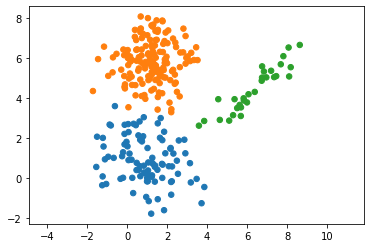

In [17]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
plt.scatter(X[:, 0], X[:, 1], c=colors[labels], s=30)
plt.axis('equal')
plt.show()